In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install eli5
!pip install pdpbox

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.metrics import *

In [ ]:
!pip install category_encoders

In [ ]:
train = pd.read_csv("/content/drive/Shareddrives/빅콘테스트/221009/1009_train.csv")
test = pd.read_csv("/content/drive/Shareddrives/빅콘테스트/221009/1009_test.csv")
real_test = pd.read_csv("/content/drive/Shareddrives/빅콘테스트/혜림/최후/preprocessed_test.csv")

In [ ]:
df_train = train[train['week_num'] <18].reset_index(drop=True)
df_val = train[train['week_num']>=18].reset_index(drop=True)
train = df_train.copy()
val = df_val.copy()

In [ ]:
train['bank_id'] = train['bank_id'].astype(str)
train['product_id'] = train['product_id'].astype(str)
train['user_id'] = train['user_id'].astype(str)

In [ ]:
val['bank_id'] = val['bank_id'].astype(str)
val['product_id'] = val['product_id'].astype(str)
val['user_id'] = val['user_id'].astype(str)

In [ ]:
test['bank_id'] = test['bank_id'].astype(str)
test['product_id'] = test['product_id'].astype(str)
test['user_id'] = test['user_id'].astype(str)

In [ ]:
real_test['bank_id'] = real_test['bank_id'].astype(str)
real_test['product_id'] = real_test['product_id'].astype(str)
real_test['user_id'] = real_test['user_id'].astype(str)

In [ ]:
test = test.sort_values(by=['application_id', 'loanapply_insert_time', 'bank_id', 'product_id', 'loan_limit']).reset_index(drop=True)

# 전처리


In [ ]:
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('is_applied')
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = train.dtypes[train.dtypes == "object"].index.tolist()
print("Number of Categorical features: ", len(categorical_feats))

test_numerical_feats = real_test.dtypes[real_test.dtypes != "object"].index.tolist()
test_numerical_feats.remove('is_applied')
print("Number of Numerical features for test: ", len(test_numerical_feats))

test_categorical_feats = real_test.dtypes[real_test.dtypes == "object"].index.tolist()
print("Number of Categorical features for test: ", len(test_categorical_feats))

Number of Numerical features:  34
Number of Categorical features:  8
Number of Numerical features for test:  34
Number of Categorical features for test:  8


In [ ]:
ordinal_cate = ['bank_id','product_id','user_id']
onehot_cate = [ 'income_type','employment_type','houseown_type','purpose']

In [ ]:
from category_encoders.ordinal import OrdinalEncoder
encoder = OrdinalEncoder(ordinal_cate)
train[ordinal_cate] = encoder.fit_transform(train[ordinal_cate], train['is_applied'])
val[ordinal_cate] = encoder.transform(val[ordinal_cate])
test[ordinal_cate] = encoder.transform(test[ordinal_cate])
real_test[ordinal_cate] = encoder.transform(real_test[ordinal_cate])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train[onehot_cate]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(val[onehot_cate]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(test[onehot_cate]))
OH_cols_real_test = pd.DataFrame(OH_encoder.transform(real_test[onehot_cate]))

OH_cols_train.index = train.index
OH_cols_valid.index = val.index
OH_cols_test.index = test.index
OH_cols_real_test.index = real_test.index

OH_cols_train.columns = OH_encoder.get_feature_names(onehot_cate)
OH_cols_valid.columns = OH_encoder.get_feature_names(onehot_cate)
OH_cols_test.columns = OH_encoder.get_feature_names(onehot_cate)
OH_cols_real_test.columns = OH_encoder.get_feature_names(onehot_cate)

num_X_train = train.drop(onehot_cate, axis=1)
num_X_valid = val.drop(onehot_cate, axis=1)
num_X_test = test.drop(onehot_cate, axis=1)
num_X_real_test = real_test.drop(onehot_cate, axis=1)


train = pd.concat([num_X_train, OH_cols_train], axis=1)
val= pd.concat([num_X_valid, OH_cols_valid], axis=1)
test= pd.concat([num_X_test, OH_cols_test], axis=1)
real_test= pd.concat([num_X_real_test, OH_cols_real_test], axis=1)

In [ ]:
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
#val[numerical_feats] = scaler.transform(val[numerical_feats])
#test[numerical_feats] = scaler.transform(test[numerical_feats])
real_test[numerical_feats] = scaler.transform(real_test[numerical_feats])

In [ ]:
target = 'is_applied'
X_train, X_valid, y_train, y_valid = train.drop(target, axis=1), val.drop(target, axis=1), train[target], val[target]
X_test, y_test = test.drop(target, axis=1), test[target]
#X_real_test = real_test.drop(target, axis=1)

## LGBM

In [ ]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import optuna

In [ ]:
import joblib
optimized_LGBM = joblib.load("/content/drive/Shareddrives/빅콘테스트/제출파일/기타 데이터?/lgbm.pkl")

In [ ]:
fitted = optimized_LGBM.fit(X_train.drop(['application_id', 'loanapply_insert_time'],axis=1), y_train)

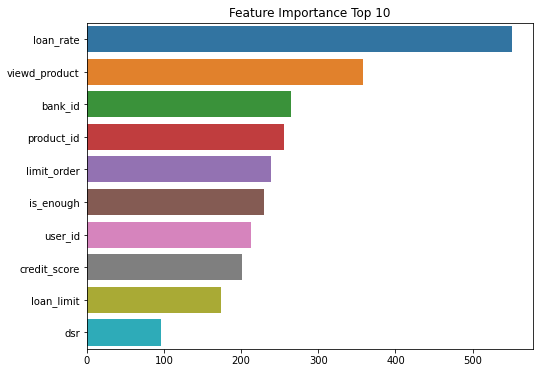

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


ft_importance_values = optimized_LGBM.feature_importances_

ft_series = pd.Series(ft_importance_values, index = X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns)
ft_top10 = ft_series.sort_values(ascending=False)[:10]

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 10')
sns.barplot(x=ft_top10, y=ft_top10.index)
plt.show()

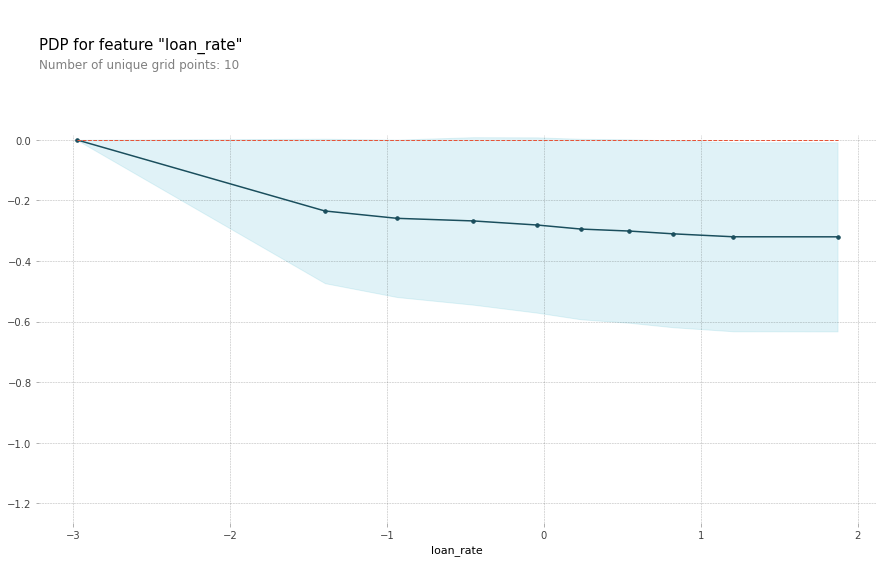

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp


selected_feature = 'loan_rate'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

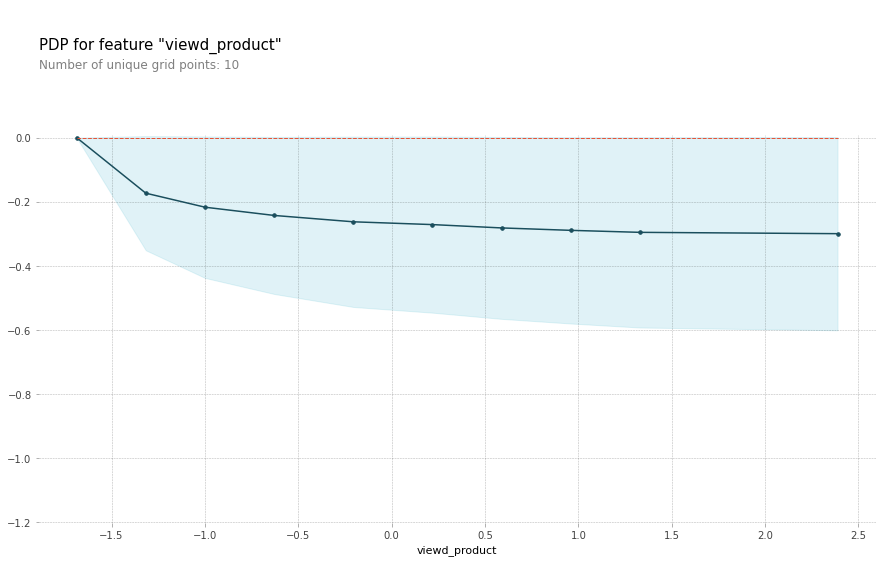

In [ ]:
selected_feature = 'viewd_product'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

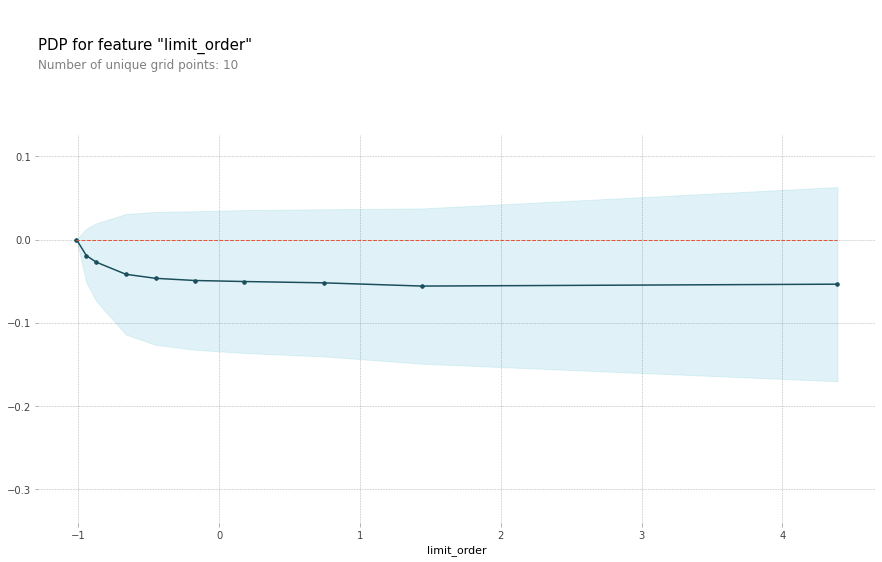

In [ ]:
selected_feature = 'limit_order'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

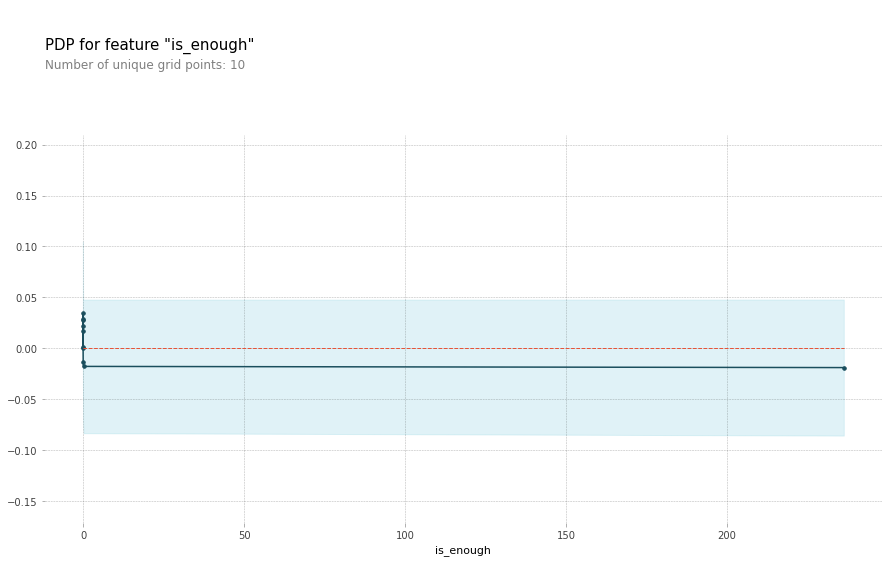

In [ ]:
selected_feature = 'is_enough'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

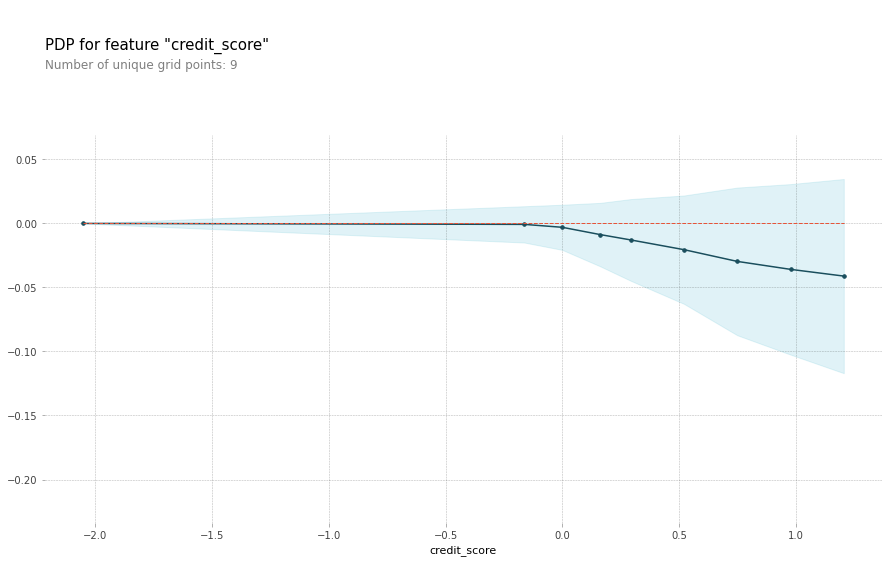

In [ ]:
selected_feature = 'credit_score'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

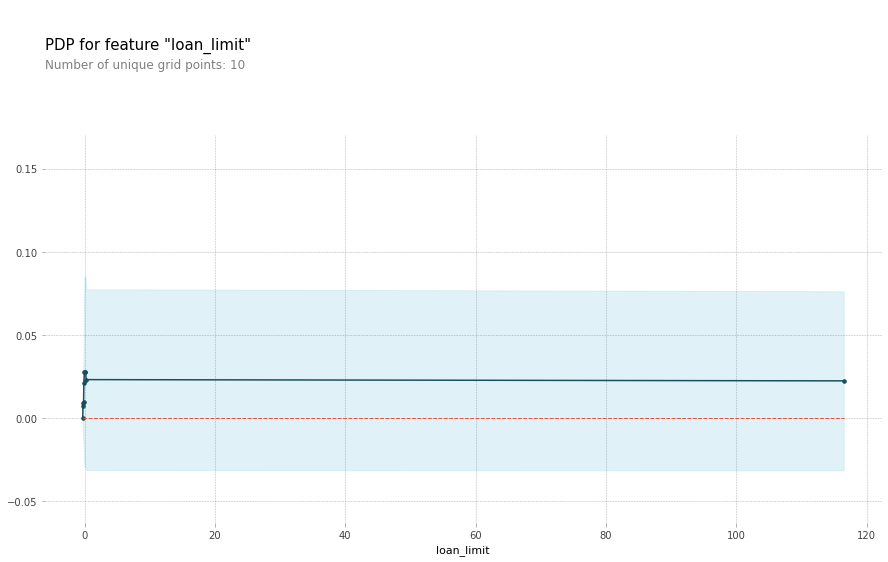

In [ ]:
selected_feature = 'loan_limit'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

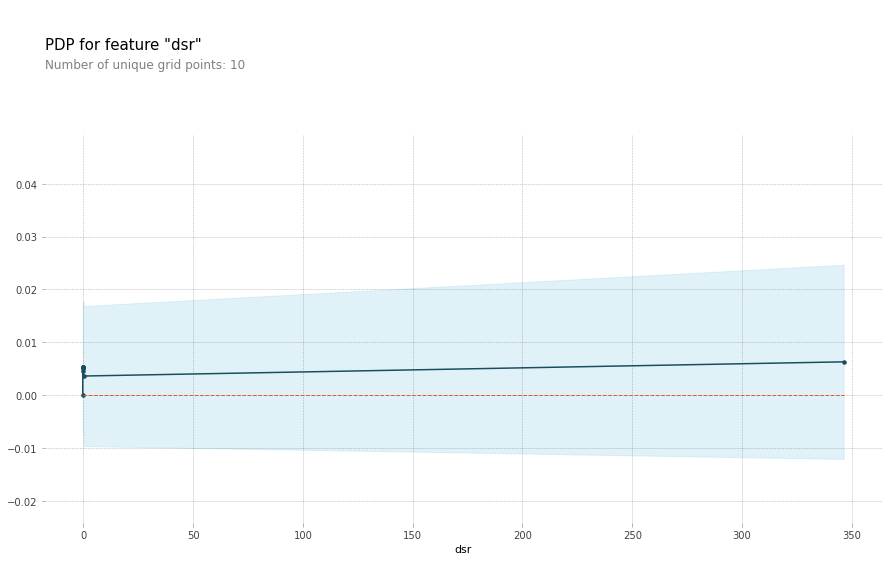

In [ ]:
selected_feature = 'dsr'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

## RF

In [ ]:
train.drop(labels=[ 'employment_type_계약직', 'income_type_EARNEDINCOME2', 'income_type_PRIVATEBUSINESS', 'purpose_사업자금', 'purpose_기타', 'income_type_FREELANCER', 
                 'income_type_OTHERINCOME', 'purpose_전월세보증금', 'employment_type_일용직', 'income_type_PRACTITIONER', 'purpose_투자', 'purpose_주택구입', 'foreign', 
                 'purpose_자동차구입', 'personal_rehabilitation_type', 'houseown_type_배우자'],axis=1,inplace=True) 
val.drop(labels=[ 'employment_type_계약직', 'income_type_EARNEDINCOME2', 'income_type_PRIVATEBUSINESS', 'purpose_사업자금', 'purpose_기타', 'income_type_FREELANCER', 
                 'income_type_OTHERINCOME', 'purpose_전월세보증금', 'employment_type_일용직', 'income_type_PRACTITIONER', 'purpose_투자', 'purpose_주택구입', 'foreign', 
                 'purpose_자동차구입', 'personal_rehabilitation_type', 'houseown_type_배우자'],axis=1,inplace=True) 

In [ ]:
target = 'is_applied'
X_train, X_valid, y_train, y_valid = train.drop(target, axis=1), val.drop(target, axis=1), train[target], val[target]
#X_real_test = real_test

In [ ]:
import joblib
optimized_RF = joblib.load("/content/drive/Shareddrives/빅콘테스트/제출파일/기타 데이터?/RF.pkl")

In [ ]:
fitted = optimized_RF.fit(X_train.drop(['application_id', 'loanapply_insert_time'],axis=1), y_train)

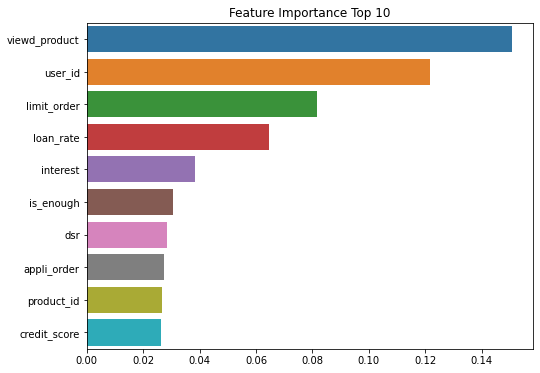

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


ft_importance_values = optimized_RF.feature_importances_

ft_series = pd.Series(ft_importance_values, index = X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns)
ft_top10 = ft_series.sort_values(ascending=False)[:10]

plt.rc('font', family='NanumBarunGothic') 
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 10')
sns.barplot(x=ft_top10, y=ft_top10.index)
plt.show()

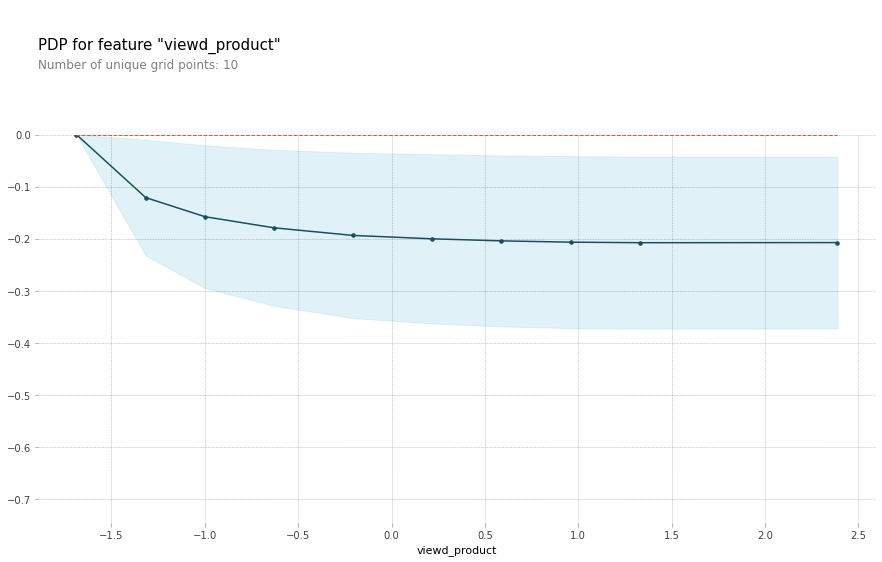

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp


selected_feature = 'viewd_product'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

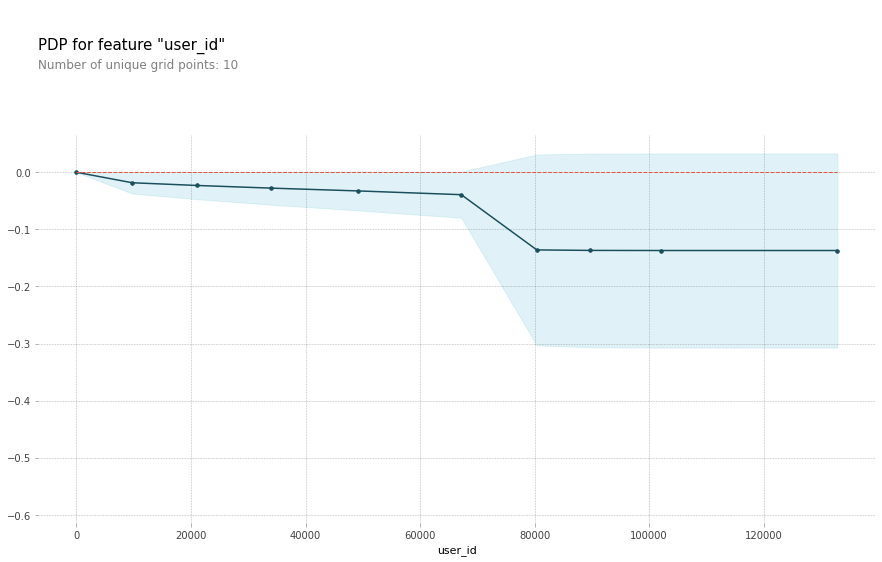

In [ ]:
selected_feature = 'user_id'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

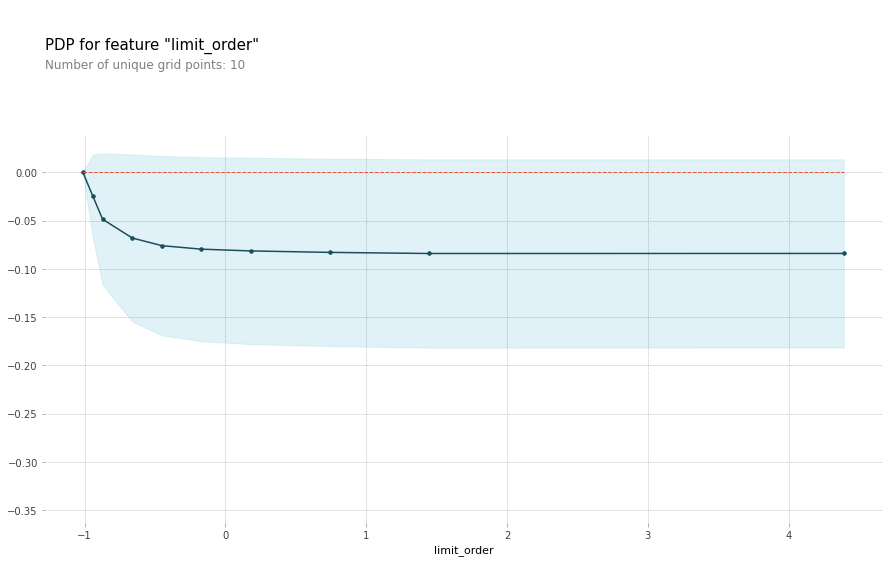

In [ ]:
selected_feature = 'limit_order'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

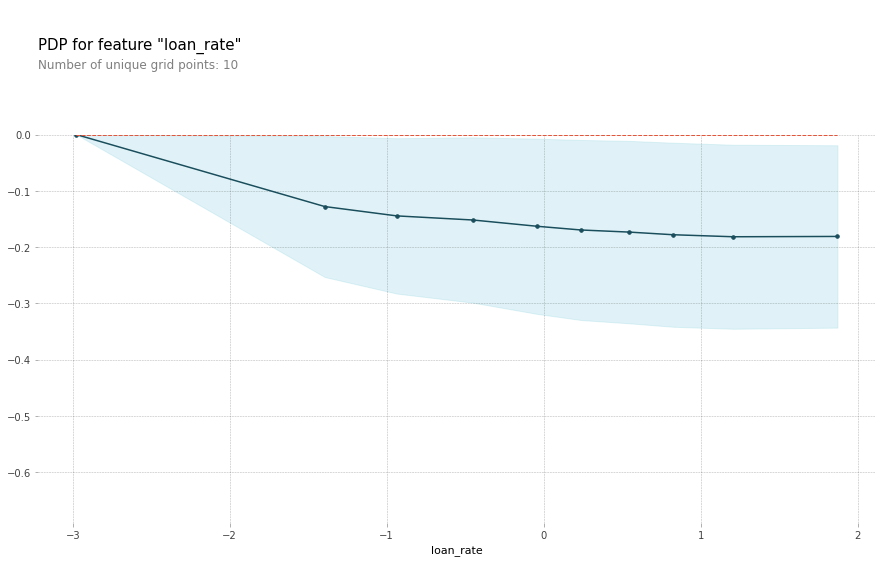

In [ ]:
selected_feature = 'loan_rate'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

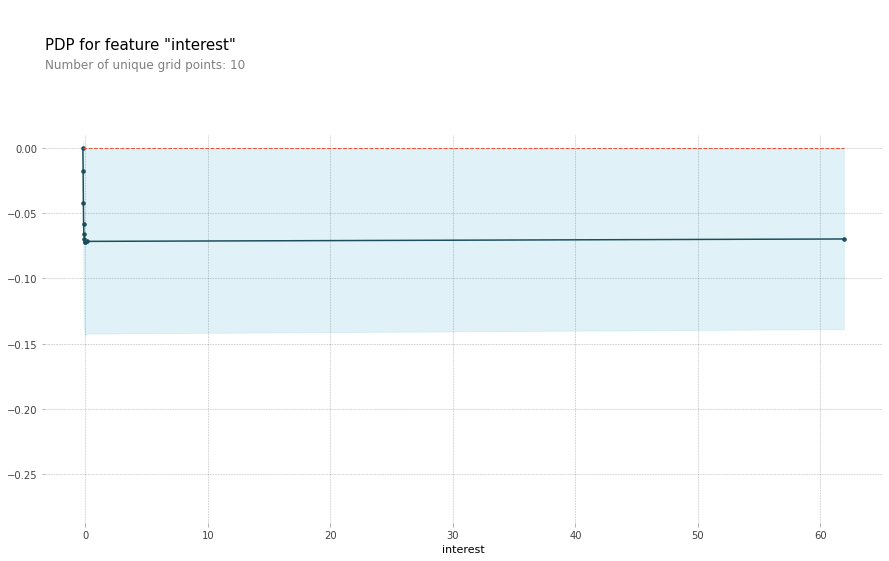

In [ ]:
selected_feature = 'interest'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

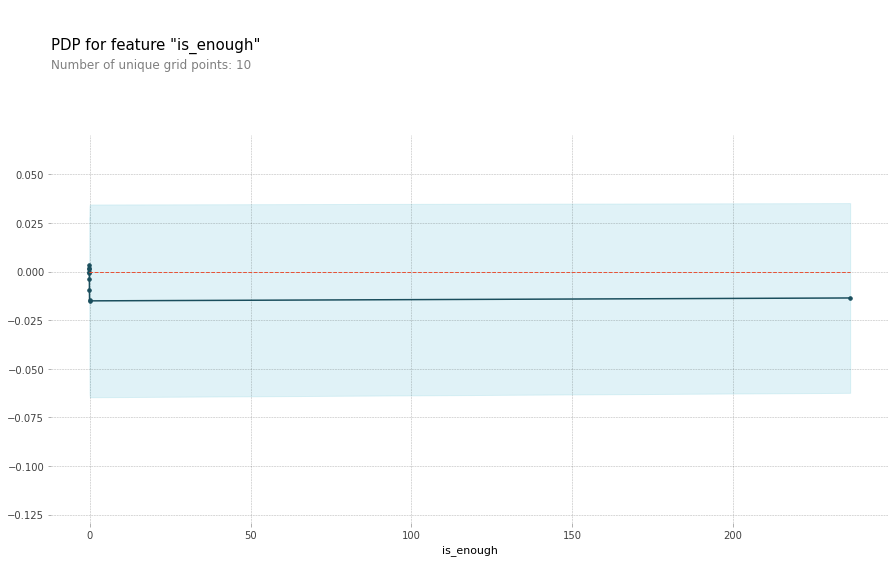

In [ ]:
selected_feature = 'is_enough'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

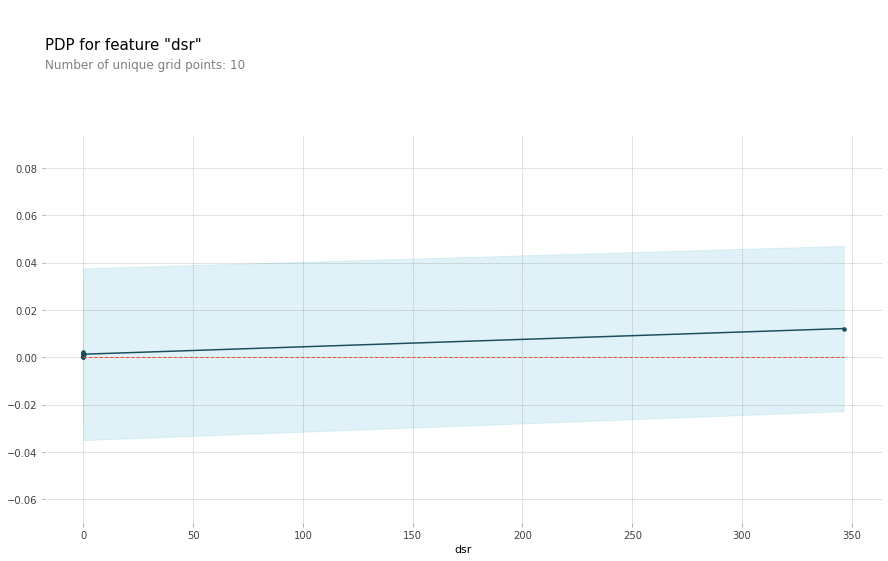

In [ ]:
selected_feature = 'dsr'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

In [ ]:
selected_feature = 'appli_order'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

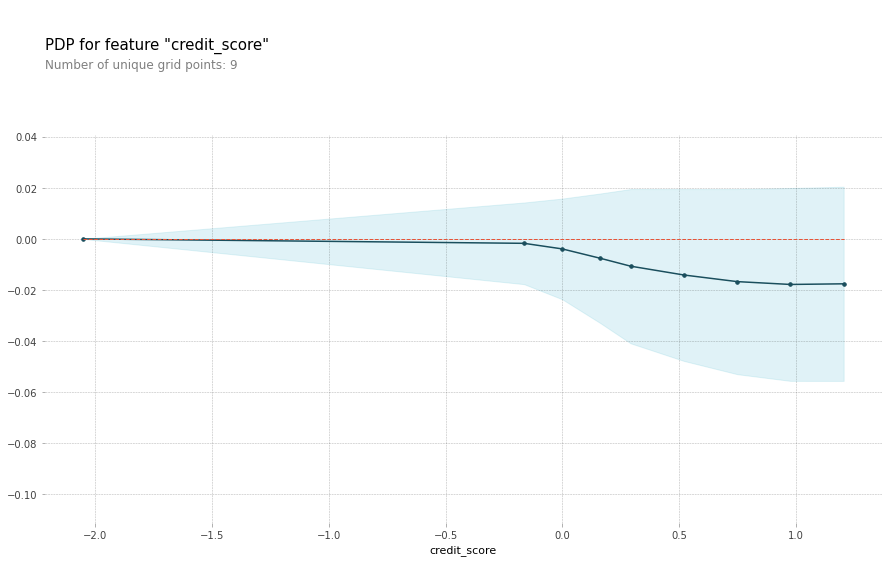

In [ ]:
selected_feature = 'credit_score'
pdp_dist = pdp_isolate(
    model=fitted,
    dataset=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1),
    model_features=X_train.drop(['application_id', 'loanapply_insert_time'],axis=1).columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);